In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

from song_db_universal import songs, SAMPLE_RATE
print(SAMPLE_RATE)

22050


In [2]:
# Retrive refs and queries
refs, queries = songs.get_all_snips(audio_len=1*SAMPLE_RATE)
print(refs.shape, queries.shape)

(25023, 22050) (6000, 22050)


In [3]:
# Shuffle and balance refs/queries
np.random.shuffle(refs)
np.random.shuffle(queries)

cut_len = min(len(refs), len(queries))

refs = refs[:cut_len]
queries = queries[:cut_len]
print(refs.shape, queries.shape)

(6000, 22050) (6000, 22050)


In [4]:
# Utilities
def preprocess(M):
    """Absolute value, log and average across time frames."""
    return np.average(np.log(1+1000000*np.absolute(M)), axis=1)

def CQT(audio_arr):
    """Compute the CQT of the given audio array."""
    return librosa.cqt(np.asfarray(audio_arr, dtype="float32"), sr=SAMPLE_RATE, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96)

In [5]:
# Compute CQT and preprocess
refCQT = []
for i, ref in enumerate(refs):
    if i % 100 == 0:
        print("Processing ref snip {}/{}...".format(i, len(refs)))
    refCQT.append(preprocess(CQT(ref)))
refCQT = np.array(refCQT)

queryCQT = []
for i, query in enumerate(queries):
    if i % 100 == 0:
        print("Processing query snip {}/{}...".format(i, len(queries)))
    queryCQT.append(preprocess(CQT(query)))
queryCQT = np.array(queryCQT)

print(refCQT.shape, queryCQT.shape)

Processing ref snip 0/6000...
Processing ref snip 100/6000...
Processing ref snip 200/6000...
Processing ref snip 300/6000...
Processing ref snip 400/6000...
Processing ref snip 500/6000...
Processing ref snip 600/6000...
Processing ref snip 700/6000...
Processing ref snip 800/6000...
Processing ref snip 900/6000...
Processing ref snip 1000/6000...
Processing ref snip 1100/6000...
Processing ref snip 1200/6000...
Processing ref snip 1300/6000...
Processing ref snip 1400/6000...
Processing ref snip 1500/6000...
Processing ref snip 1600/6000...
Processing ref snip 1700/6000...
Processing ref snip 1800/6000...
Processing ref snip 1900/6000...
Processing ref snip 2000/6000...
Processing ref snip 2100/6000...
Processing ref snip 2200/6000...
Processing ref snip 2300/6000...
Processing ref snip 2400/6000...
Processing ref snip 2500/6000...
Processing ref snip 2600/6000...
Processing ref snip 2700/6000...
Processing ref snip 2800/6000...
Processing ref snip 2900/6000...
Processing ref snip 30

In [6]:
# Separate into training and testing datasets
training_p = 0.6
ref_p = int(training_p*refs.shape[0])
query_p = int(training_p*queries.shape[0])
print(ref_p, query_p)

3600 3600


In [7]:
X = np.concatenate((refCQT, queryCQT), axis=0)
y = np.array([0]*refs.shape[0] + [1]*queries.shape[0])

X_train = np.concatenate((refCQT[:ref_p], queryCQT[:query_p]), axis=0)
X_test = np.concatenate((refCQT[ref_p:], queryCQT[query_p:]), axis=0)
y_train = np.array([0]*ref_p + [1]*query_p)
y_test = np.array([0]*(refs.shape[0]-ref_p) + [1]*(queries.shape[0]-query_p))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7200, 121) (7200,) (4800, 121) (4800,)


In [8]:
# SVC Model
from sklearn.svm import SVC, LinearSVC
clf = SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [9]:
print("Train accuracy:", clf.score(X_train, y_train))
print("Test accuracy:", clf.score(X_test, y_test))

0.9238888888888889
0.8995833333333333


In [10]:
# Project features to 2-D plot
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

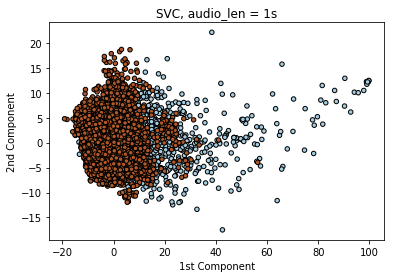

In [11]:
# Scatter plot of all data points
plt.figure()
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, zorder=10, cmap=plt.cm.Paired, edgecolor="k", s=20)
plt.xlabel("1st Component")
plt.ylabel("2nd Component")
plt.title("SVC, audio_len = 1s")
plt.show()